# Welcome to the AIMS Jupyter Notebook!
# As a refresher, hit ctrl + enter to run each cell
I tried to add comments and other markdown cells like this one where appropriate to help with interpretations. This first cell is just loading in all of the necessary python modules (which you should have already installed)

In [1]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import rc
import pandas

# THIS LAST BIT IS TO NAVIAGATE TO WHERE MY CUSTOM MODULES ARE LOCATED
import os
if os.getcwd()[-14:] != 'AIMS':
    default_path = os.getcwd()[:-10]
    os.chdir(default_path)
import aims_loader as aimsLoad
import aims_analysis as aims
import aims_classification as classy

# Here is the Notebook Version of the AIMS GUI, Edited for Anaylsis of Singular Populations
Quite different from the original AIMS app, but sometimes you don't want to compare two groups, you just want to find interesting populations in a singular dataset. This notebook code should be quite flexible, and you really should only have to customize the below cell and then run the rest of the cells as-is. Here, we START with a PCA/UMAP breakdown of the dataset, then isolate 2 populations of interest, and use our standard AIMS binary analysis.

In [2]:
# Define how many CDR loops are in the files you are loading
num_loop=1
# Definte the names of the subgroups you are analyzing
label = ['TL8']

# Load in the files you want to analyze. Place the path to your directory in single quotes
# Ideally there won't be spaces in file or folder names. Check example files for proper formatting of csv or txt files
seq1 = aimsLoad.Ig_loader('app_data/siv_tl8.csv',label=label[0],loops=num_loop,drop_degens = True)

# If running on a mac, set parallel process to True for a speedup
# parallel processing has not yet been tested on other (non macOS) operating systems
parallel_process = False
# At one point we will break down our dataset into N top properties which best split these two subgroups
# Define that N here as "finalSize". Shouldn't make too large
# In classification applications must be particularly worried about overfitting with large N
finalSize = 10

In [3]:
num_loop=1
mat_size = aims.get_sequence_dimension(np.array(seq1))[0]
AA_num_key = aims.get_props()[1]

In [4]:
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 20}
COLOR = 'black'
rcParams['text.color'] = 'black'
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

rc('font', **font)

# Custom colormap code from: https://stackoverflow.com/questions/49367144/modify-matplotlib-colormap
import matplotlib as mpl
upper = mpl.cm.jet(np.arange(256))
lower = np.ones((int(256/4),4))
for i in range(3):
    lower[:,i] = np.linspace(1, upper[0,i], lower.shape[0])

cmap = np.vstack(( lower, upper ))
cmap = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])

In [5]:
if num_loop != 1:
    for i in np.arange(len(mat_size)):
        if i == 0:
            xtick_loc = [mat_size[i]/2]
        else:
            pre_loc = sum(mat_size[:i])
            xtick_loc = xtick_loc + [mat_size[i]/2 + pre_loc]
else:
    xtick_loc = mat_size/2

# ALIGNMENT OPTIONS are bulge, center, left, and right... pretty self explanatory besides bulge
Bulge aligns the germline regions of CDR3 (and other loops) and then center aligns what is left. Change the 'align' variable to one of these three. Pretty easy to visualize each time you do so in below matrix

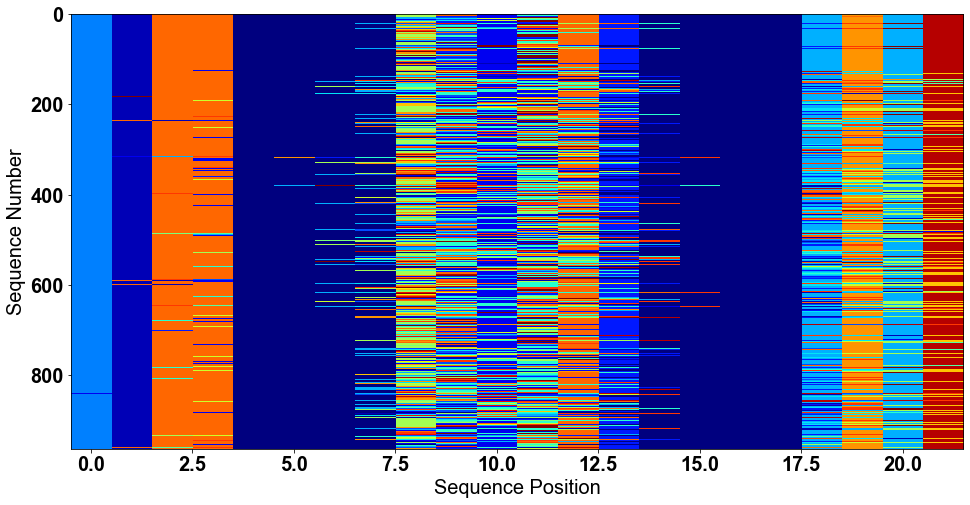

In [6]:
align = 'bulge'
#cen_only = False # This is an option if you have nearly identical V- and J- gene segments across sequences, drops those regions
seq_MIpre = aims.gen_tcr_matrix(np.array(seq1),key = AA_num_key, giveSize = mat_size, alignment = align)
seq_MIf = pandas.DataFrame(np.transpose(seq_MIpre),columns = seq1.columns)

fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
ax[0,0].imshow(np.transpose(seq_MIf), interpolation='nearest', aspect='auto',cmap=cm.jet)
ax[0,0].set_ylabel('Sequence Number')

######
# It will help to have vertical white lines to guide the viewer
seq1_len = np.shape(seq1)[1]
Numclones = int(seq1_len)
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(Numclones),np.arange(Numclones),'white',linewidth = 3)
#######

if num_loop == 1:
    ax[0,0].set_xlabel('Sequence Position')
elif num_loop == 2:
    ax[0,0].set_xticks(xtick_loc)
    ax[0,0].set_xticklabels(['CDR3L','CDR3H'])
elif num_loop == 6:
    ax[0,0].set_xticks(xtick_loc)
    ax[0,0].set_xticklabels(['CDR1L','CDR2L','CDR3L','CDR1H','CDR2H','CDR3H'])
# Can also edit the saved figure name and format, if you want
#pl.savefig('AIMS_mat.pdf',format='pdf')

In [7]:
# Process this new matrix and apply biophysical propery "masks"
# This has to be changed from the binary case, because we aren't looking for differences
dsetF = seq1.values
#################### PARALLEL PROCESSING TO CREATE BIG MATRIX #######################
if parallel_process:
    import multiprocessing as mp
    def boot_it(data):
        bigass = classy.get_bigass_matrix(dsetF[:,data[0]:data[1]], giveSize = mat_size, alignment = align, norm=True)
        return(bigass)
    def do_boot(data):
        with mp.Pool() as pool:
            results = pool.map(boot_it, data)
            return(results)
    if __name__ == "__main__":
        # Probably a smarter way to calculate #seqs per node, but do 100 for now
        final = aims.gen_splits(splitMat = seq_MIf, splitSize = 100)
        big_pre = do_boot(final)
    total_mat = np.concatenate(big_pre, axis = 0)
else:
    bigass = classy.get_bigass_matrix(dsetF, giveSize = mat_size, alignment = align, norm = True )
    total_mat = bigass
    
### So in normal script, we have further processing for this BIG matrix... For this, lets just take out correlated data
prop_list_old = ['Phobic1','Charge','Phobic2','Bulk','Flex','Kid1','Kid2','Kid3','Kid4','Kid5','Kid6','Kid7','Kid8','Kid9','Kid10']
prop_list_new = ['Hot'+str(b+1) for b in range(46)]

prop_names = prop_list_old + prop_list_new
num_locs = int(np.shape(total_mat)[1]/61)
Bigass_names = []
for i in prop_names:
    for j in np.arange(num_locs):
        Bigass_names = Bigass_names + [ i + '-' + str(j) ]

# AND THEN GO ON WITH THE REST OF THE dropping of correlated vectors
full_big = pandas.DataFrame(total_mat,columns = Bigass_names)
drop_zeros = [column for column in full_big.columns if all(full_big[column] == 0 )]
y = full_big.drop(full_big[drop_zeros], axis=1)
z_pre = np.abs(np.corrcoef(np.transpose(y)))
z = pandas.DataFrame(z_pre,columns=y.columns,index=y.columns)
# Select upper triangle of correlation matrix
upper = z.where(np.triu(np.ones(z.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if ( any(upper[column] > 0.75) ) ]

parsed_mat = y.drop(y[to_drop], axis=1)

# The next few cells are particularly powerful for isolating interesting populations in the dataset using PCA, UMAP, and KMeans Clustering
Again, you really shouldn't need to change ANYTHING save for the number of clusters in each clustering instance and the few specific populations you may want to look at more closely

[0.07720492 0.0511769  0.04711493]


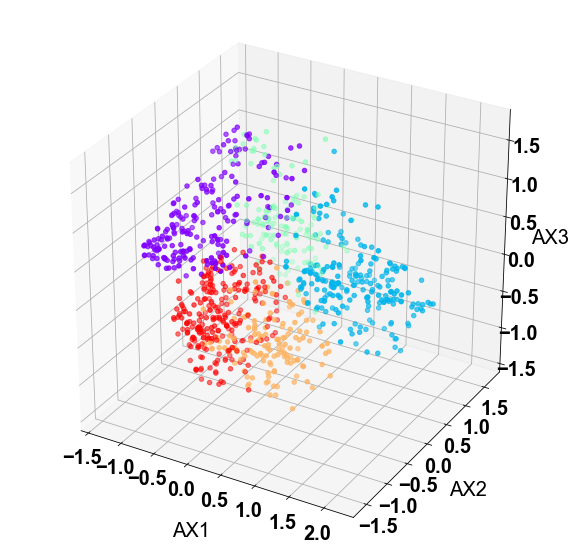

In [8]:
# Perform UMAP on the whole dataset?
#chosen_dset = full_big.drop(columns='ID')
# Or perform it on the dataset with correlated vectors removed?
chosen_dset = parsed_mat

# Want to run pca or umap?
reduce = 'pca'
# What will you cluster with (kmean, optics, dbscan)?
clust = 'kmean'

if reduce == 'pca':
    from sklearn.decomposition import PCA
    pca = PCA(n_components=3, svd_solver='full')
    final=pca.fit_transform(chosen_dset)
    transform = pandas.DataFrame(np.transpose(final),columns = seq_MIf.columns)
    print(pca.explained_variance_ratio_)
elif reduce == 'umap':
    import umap
    reducer = umap.UMAP(n_components=3, n_neighbors = 25)
    final = reducer.fit_transform(chosen_dset)
    transform = pandas.DataFrame(np.transpose(final),columns = seq_MIf.columns)

from mpl_toolkits import mplot3d
fig3d = pl.figure(figsize = (10, 10))
ax3d = fig3d.add_subplot(111, projection='3d')

# Cluster the results:
import sklearn.cluster as cluster
clust_input = np.array(np.transpose(transform))
if clust == 'kmean':
    NClust = 5
    clusts = cluster.KMeans(n_clusters=NClust).fit_predict(clust_input)
elif clust == 'optics':
    clusts = cluster.OPTICS(min_samples=10).fit_predict(clust_input)
elif clust == 'dbscan':
    clusts = cluster.DBSCAN(eps=0.3).fit_predict(clust_input)

cluster_dset = pandas.DataFrame(clusts,columns=['cluster'])
# Want the min cluster to be white for non kmean cluster, as these are unclustered
if clust == 'kmean':
    ax3d.scatter(clust_input[:,0],clust_input[:,1],clust_input[:,2],c = clusts, cmap='rainbow')
else:
    ax3d.scatter(clust_input[:,0],clust_input[:,1],clust_input[:,2],c = clusts, cmap=cmap)

ax3d.set_xlabel('AX1',labelpad=20)
ax3d.set_ylabel('AX2',labelpad=20)
ax3d.set_zlabel('AX3',labelpad=10)
#pl.savefig('AIMS_PCA3D.pdf',DPI=500,format='pdf')
pl.show()

Text(0, 0.5, 'AX2')

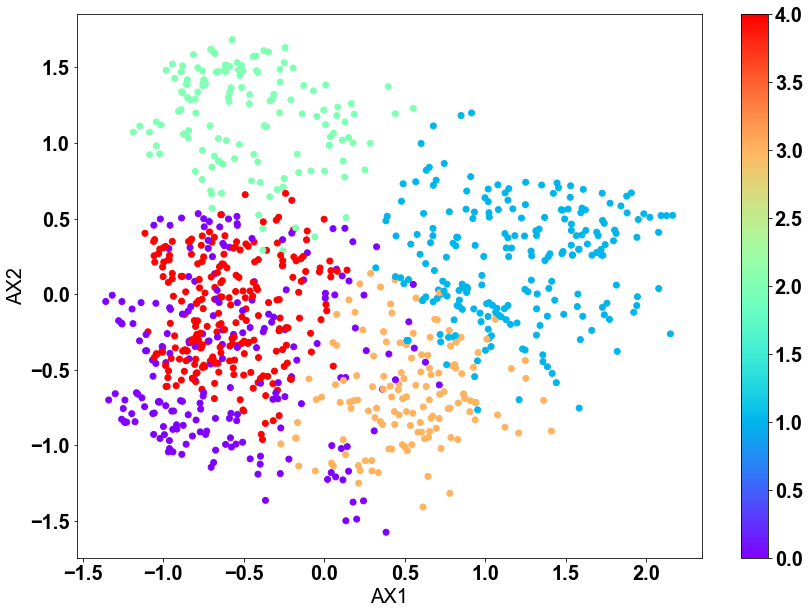

In [9]:
fig = pl.figure(figsize = (14, 10))
if clust == 'kmean':
    x = pl.scatter(clust_input[:,0],clust_input[:,1],c = clusts, cmap='rainbow')
else:
    x = pl.scatter(clust_input[:,0],clust_input[:,1],c = clusts, cmap=cmap)

zz = pl.colorbar(x)    
pl.xlabel('AX1'); pl.ylabel('AX2')
#pl.savefig('AIMS_PCA2D.pdf',format='pdf')

Text(0, 0.5, 'Sequence Number')

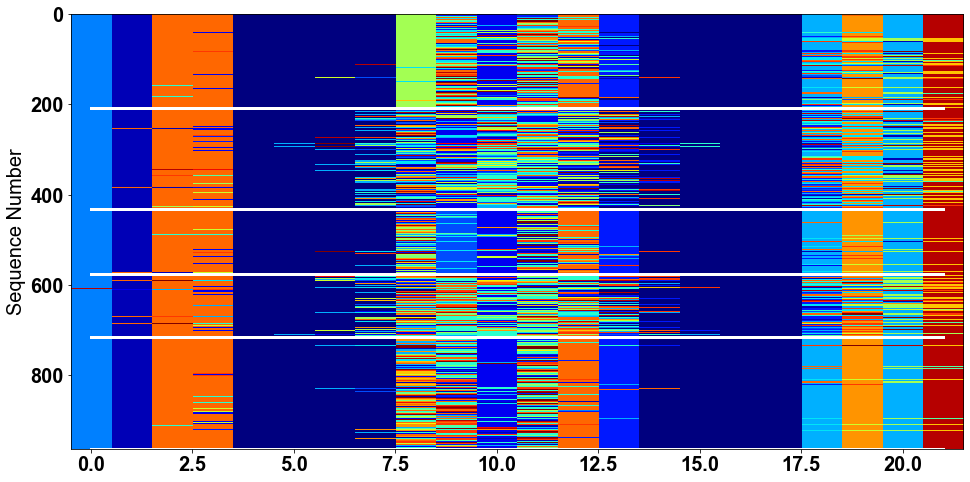

In [10]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
for i in np.sort(cluster_dset['cluster'].drop_duplicates()):
    if i == -1:
        continue
    pre_clust = seq_MIf[seq_MIf.columns[cluster_dset[cluster_dset['cluster'] == i].index]]
    clustID = np.transpose(pandas.DataFrame(i*np.ones(np.shape(pre_clust)[1])))
    clustID.columns = pre_clust.columns
    pre_clustF = pandas.concat([pre_clust,clustID],axis=0)
    if i == 0:
        clustered = pre_clustF
    else:
        clustered = pandas.concat([clustered, pre_clustF],axis = 1)
    ax[0,0].plot(np.arange(len(seq_MIf)),np.ones(len(seq_MIf))*(np.shape(clustered)[1]),'white',linewidth = 3)

xyz = ax[0,0].imshow(np.transpose(np.array(clustered))[:,:-1], interpolation='nearest', aspect='auto',cmap=cm.jet)
ax[0,0].set_ylabel('Sequence Number')
#pl.savefig('AIMS_clustMat.pdf',format='pdf')

# As a final section, we can isolate individual clusters from UMAP or PCA for further inspection
Run the next cell to visualize certain clusters, then the cell after to save these sequences in separate files and potentially use seqlogo to visualize.

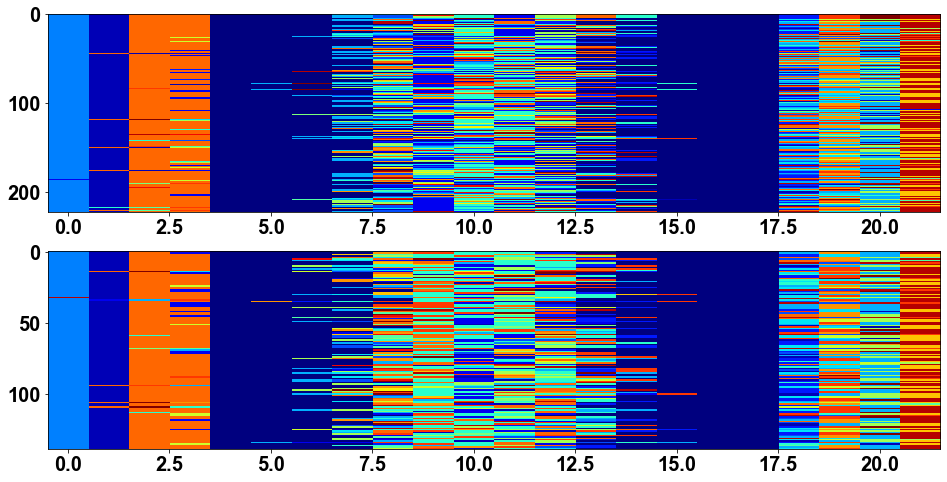

In [12]:
# So now that we've done some clustering, pick out the most interesting clusters:
sel1 = 1
sel2 = 3
# Look at umap dset or pca dset
sub1_MI = seq_MIf[seq_MIf.columns[cluster_dset[cluster_dset['cluster'] == sel1].index]]
sub2_MI = seq_MIf[seq_MIf.columns[cluster_dset[cluster_dset['cluster'] == sel2].index]]

# Alright now get the sequences
dset = seq1
sub1_seqs = np.transpose(dset[sub1_MI.columns])
sub2_seqs = np.transpose(dset[sub2_MI.columns])

label=['sub1','sub2']

fig, ax = pl.subplots(2, 1,squeeze=False,figsize=(16,8))
ax[0,0].imshow(np.transpose(sub1_MI), interpolation='nearest', aspect='auto',cmap=cm.jet)
ax[1,0].imshow(np.transpose(sub2_MI), interpolation='nearest', aspect='auto',cmap=cm.jet)

# Only run the next two cells if you have seqlogo installed (or if you want to save the sequences isolated above
You can download command line seqlogo here: https://weblogo.berkeley.edu/

In [13]:
# Alright now that we know we're looking at the clusters we are interested in, analyze!
# We need to single out sequences of a singular length for seqlogo analysis... Can't analyze different lengths
seqlogo1 = sub1_seqs[sub1_seqs[0].str.len() == 14]
seqlogo2 = sub2_seqs[sub2_seqs[0].str.len() == 14]
# seqlogo takes a stripped down input:
seqlogo1.to_csv(label[0]+'_logo.txt',header=None,index=None)
seqlogo2.to_csv(label[1]+'_logo.txt',header=None,index=None)

# Do you want the full list of sequences? Do this:
sub1_seqs.to_csv(label[0]+'_all.txt',header=None,index=None)
sub2_seqs.to_csv(label[1]+'_all.txt',header=None,index=None)

In [14]:
%%bash
# Alright let's cheat and just use the seqlogo in bash... the python script is a little bit of a pain.
# Code is from reference: 
#Crooks GE, Hon G, Chandonia JM, Brenner SE WebLogo: A sequence logo generator, Genome Research, 14:1188-1190, (2004)

# Obviously, change this path to wherever YOUR seqlogo is.
#weblogo/seqlogo -F PDF -c -n -Y -f sub1_logo.txt > sub1_logo.pdf
#weblogo/seqlogo -F PDF -c -n -Y -f sub2_logo.txt > sub2_logo.pdf

# NOW we basicaly just copy line for line what is happening in the AIMS_notebook

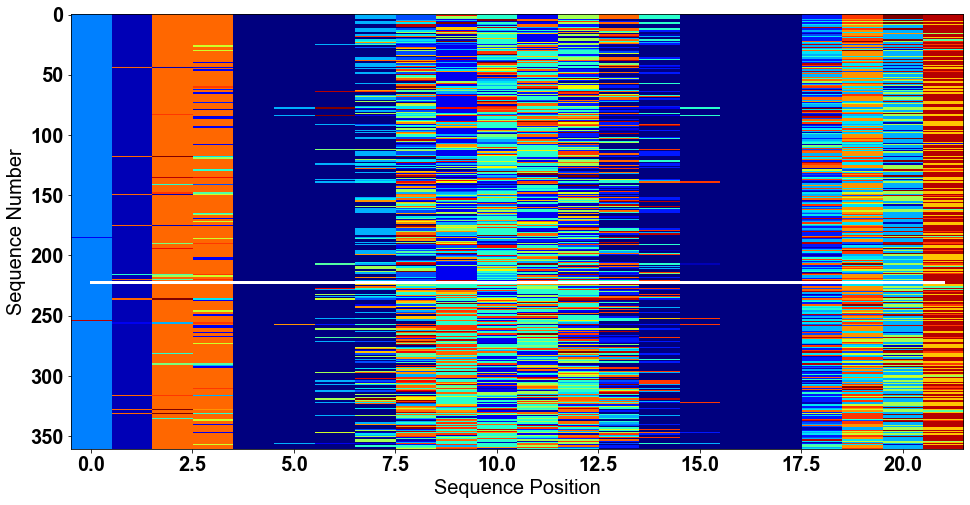

In [15]:
# Here we are getting the data into an AIMS-readable format... A numpy matrix
align = 'bulge'
seq_MI1 = aims.gen_tcr_matrix(np.transpose(np.array(sub1_seqs)),key = AA_num_key, giveSize = mat_size, alignment = align)
seq_MI2 = aims.gen_tcr_matrix(np.transpose(np.array(sub2_seqs)),key = AA_num_key, giveSize = mat_size, alignment = align)
seq_MIp1 = pandas.DataFrame(np.transpose(seq_MI1),columns = sub1_seqs.index)
seq_MIp2 = pandas.DataFrame(np.transpose(seq_MI2),columns = sub2_seqs.index)
seq_MIf = pandas.concat([seq_MIp1,seq_MIp2],axis=1)
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
ax[0,0].imshow(np.transpose(seq_MIf), interpolation='nearest', aspect='auto',cmap=cm.jet)
ax[0,0].set_ylabel('Sequence Number')

# Plot a single line delineating the distinct groups we are studying.
ax[0,0].plot(np.arange(len(seq_MIf)),np.ones(len(seq_MIf))*len(seq_MI1),'white',linewidth = 3)
######
# It will help to have vertical white lines to guide the viewer
seq1_len = np.shape(sub1_seqs)[0]; seq2_len = np.shape(sub2_seqs)[0]
Numclones = int(seq1_len + seq2_len)
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(Numclones),np.arange(Numclones),'white',linewidth = 3)
#######

if num_loop == 1:
    ax[0,0].set_xlabel('Sequence Position')
elif num_loop == 2:
    ax[0,0].set_xticks(xtick_loc)
    ax[0,0].set_xticklabels(['CDR3L','CDR3H'])
elif num_loop == 6:
    ax[0,0].set_xticks(xtick_loc)
    ax[0,0].set_xticklabels(['CDR1L','CDR2L','CDR3L','CDR1H','CDR2H','CDR3H'])
# Can also edit the saved figure name and format, if you want
#pl.savefig('AIMS_mat_subsets.pdf',format='pdf')

In [16]:
# Process this new matrix and apply biophysical propery "masks"
subSeq1 = np.transpose(sub1_seqs); subSeq2 = np.transpose(sub2_seqs)
dsetF = np.hstack((subSeq1.values,subSeq2.values))
#################### PARALLEL PROCESSING TO CREATE BIG MATRIX #######################
if parallel_process:
    import multiprocessing as mp
    def boot_it(data):
        bigass = classy.get_bigass_matrix(dsetF[:,data[0]:data[1]], giveSize = mat_size, alignment = align, norm=True)
        return(bigass)
    def do_boot(data):
        with mp.Pool() as pool:
            results = pool.map(boot_it, data)
            return(results)
    if __name__ == "__main__":
        # Probably a smarter way to calculate #seqs per node, but do 100 for now
        final = aims.gen_splits(splitMat = seq_MIf, splitSize = 100)
        big_pre = do_boot(final)
    # Still need to input seq1/seq2 for 
    full_big, weights, acc_all, mda_all, parsed_mat, top_names = aims.compile_MP(big_pre, subSeq1.values, subSeq2.values, final_size = finalSize)
else:

    full_big, weights, acc_all, mda_all, parsed_mat, top_names= classy.do_linear_split(subSeq1.values, subSeq2.values, 
                                                                           giveSize = mat_size, ridCorr = True, matSize = finalSize)

In [17]:
# One last little bit of reformatting here
seq1_bigF, seq2_bigF = aims.split_reshape(full_big, matShape = len(seq_MIf), total_props = 61)

# Now we've done all of the pre-processing, generate figures next

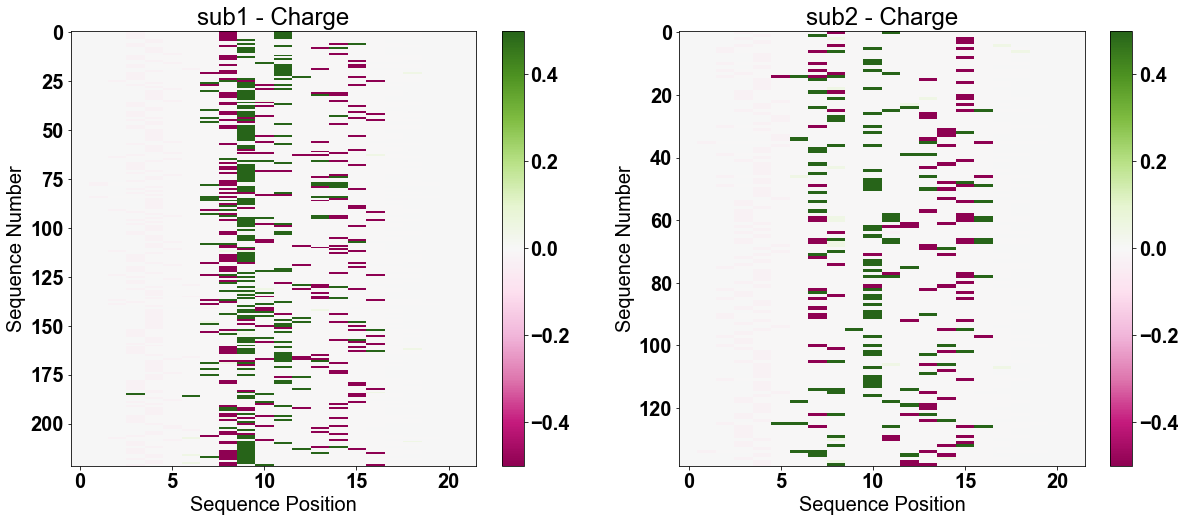

In [18]:
# Generate the position sensitive charge across all clones in the dataset
# Which property will you want to look at down the line? 1 = charge, 2 = hydrophobicity... see full list in eLife paper (Boughter et al. 2020)
prop1 = 1
fig, axs = pl.subplots(1, 2,squeeze=False,figsize=(20,8))
ax1 = axs[0, 0]; ax2 = axs[0, 1]
x = ax1.imshow(seq1_bigF[:,prop1,:],interpolation='nearest', aspect='auto',cmap=cm.PiYG, vmin = -0.5, vmax = 0.5)
y = ax2.imshow(seq2_bigF[:,prop1,:],interpolation='nearest', aspect='auto',cmap=cm.PiYG, vmin= -0.5, vmax = 0.5)
ax1.set_xlabel('Sequence Position'); ax2.set_xlabel('Sequence Position')
ax1.set_ylabel('Sequence Number'); ax2.set_ylabel('Sequence Number')
ax1.set_title(label[0] + ' - Charge'); ax2.set_title(label[1] + ' - Charge')
fig.colorbar(x, ax=axs[0,0]); fig.colorbar(y, ax=axs[0,1])
#pl.savefig('AIMS_chargeMat.pdf',format='pdf')

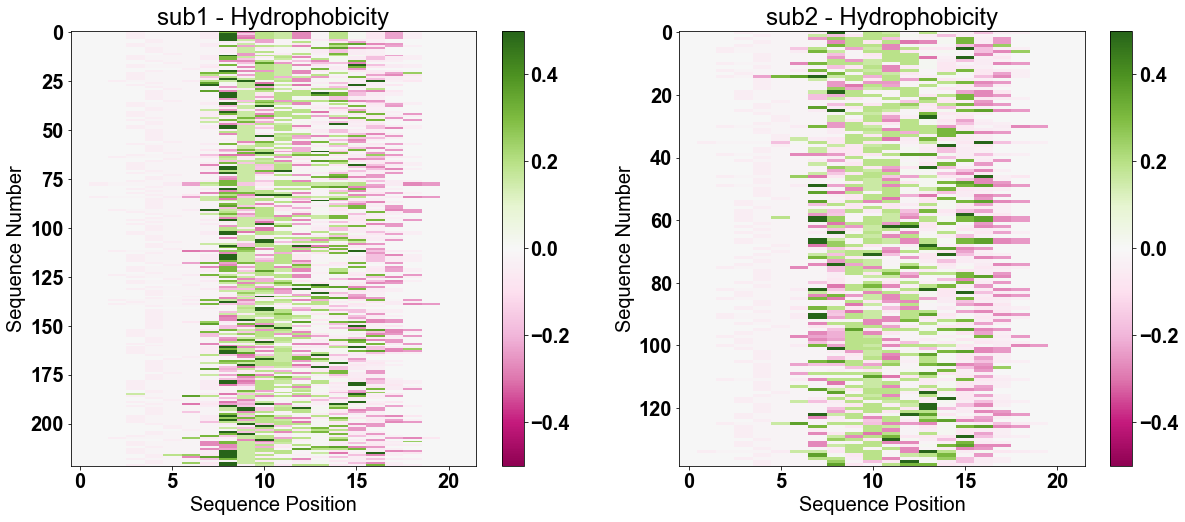

In [19]:
# Generate the position sensitive hydrophobicity across all clones in the dataset
# Which property will you want to look at down the line? 1 = charge, 2 = hydrophobicity... see full list in eLife paper (Boughter et al. 2020)
prop1 = 2
fig, axs = pl.subplots(1, 2,squeeze=False,figsize=(20,8))
ax1 = axs[0, 0]; ax2 = axs[0, 1]
x = ax1.imshow(seq1_bigF[:,prop1,:],interpolation='nearest', aspect='auto',cmap=cm.PiYG,vmax=0.5, vmin=-0.5)
y = ax2.imshow(seq2_bigF[:,prop1,:],interpolation='nearest', aspect='auto',cmap=cm.PiYG,vmax=0.5, vmin=-0.5)
ax1.set_xlabel('Sequence Position'); ax2.set_xlabel('Sequence Position')
ax1.set_ylabel('Sequence Number'); ax2.set_ylabel('Sequence Number')
ax1.set_title(label[0] + ' - Hydrophobicity'); ax2.set_title(label[1] + ' - Hydrophobicity')
fig.colorbar(x, ax=axs[0,0]); fig.colorbar(y, ax=axs[0,1])
#pl.savefig('AIMS_phobMat.pdf',format='pdf')

Text(0, 0.5, 'Normalized Property Value')

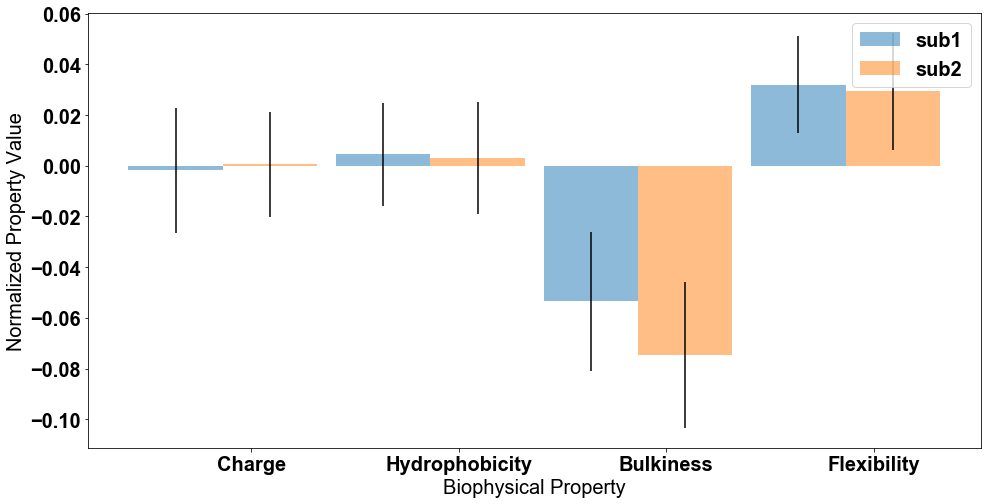

In [20]:
# Look at biophysical properties averaged over clones AND position
# Note for old users of the software, you might get different looking results because
# originally I normalized vectors to unit length, but NOT 0 mean. I now do both.
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
x_axis = np.array([-0.2,0.9,2,3.1])
# Need to have some kind of color wheel to replace this...
# We want to exclude prop0 (the simple 1-21 AA representation entries)
for prop in np.arange(4):
    propF = prop+1
    plotProp1 = np.average(np.average(seq1_bigF[:,propF,:],axis = 1))
    plotProp2 = np.average(np.average(seq2_bigF[:,propF,:],axis = 1))
    plotstd1 = np.std(np.average(seq1_bigF[:,propF,:],axis = 1))
    plotstd2 = np.std(np.average(seq2_bigF[:,propF,:],axis = 1))
    if prop == 0:
        plot1 = plotProp1; std1 = plotstd1
        plot2 = plotProp2; std2 = plotstd2
    else:
        plot1 = np.hstack((plot1,plotProp1)); std1 = np.hstack((std1,plotstd1))
        plot2 = np.hstack((plot2,plotProp2)); std2 = np.hstack((std2,plotstd2))
        
ax[0,0].bar(x_axis, plot1,
            yerr = std1,alpha = 0.5, width = 1/len(label))
ax[0,0].bar(x_axis+1/len(label), plot2,
            yerr = std2,alpha = 0.5, width = 1/len(label))
        
ax[0,0].legend(label)
ax[0,0].set_xticks([0.2,1.3,2.4,3.5])
ax[0,0].set_xticklabels(['Charge','Hydrophobicity','Bulkiness','Flexibility'])
ax[0,0].set_xlabel('Biophysical Property')
ax[0,0].set_ylabel('Normalized Property Value')
#pl.savefig('AIMS_netProp.pdf',format='pdf')

Text(0, 0.5, 'Normalized Hydrophobicity')

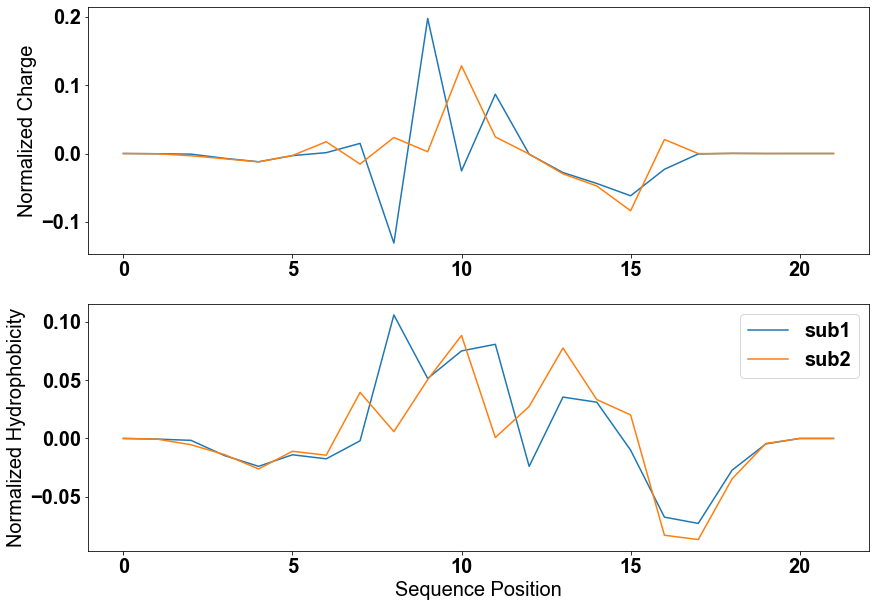

In [21]:
# Now get the position sensitive avarege biophysical properties
fig, ax = pl.subplots(2, 1,squeeze=False,figsize=(14,10))
prop1 = 1
plotProp11 = np.average(seq1_bigF[:,prop1,:],axis = 0); plotProp21 = np.average(seq2_bigF[:,prop1,:],axis = 0)
ax[0,0].set_ylabel('Charge')
ax[0,0].plot(plotProp11); ax[0,0].plot(plotProp21)

prop2 = 2
plotProp12 = np.average(seq1_bigF[:,prop2,:],axis = 0); plotProp22 = np.average(seq2_bigF[:,prop2,:],axis = 0)
ax[1,0].set_ylabel('Hydrophobicity'); ax[1,0].plot(plotProp12)
ax[1,0].plot(plotProp22); ax[1,0].set_xlabel('Sequence Position')
pl.legend(label)

# Draw some nice lines to guide 
y11, y12 = ax[0,0].get_ylim();y21, y22 = ax[1,0].get_ylim()
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(y11,y12,100),'black',linewidth = 3)
        ax[1,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(y21,y22,100),'black',linewidth = 3)

ax[0,0].set_ylabel('Normalized Charge')
ax[1,0].set_ylabel('Normalized Hydrophobicity')
#pl.savefig('AIMS_posProp.pdf',format='pdf')

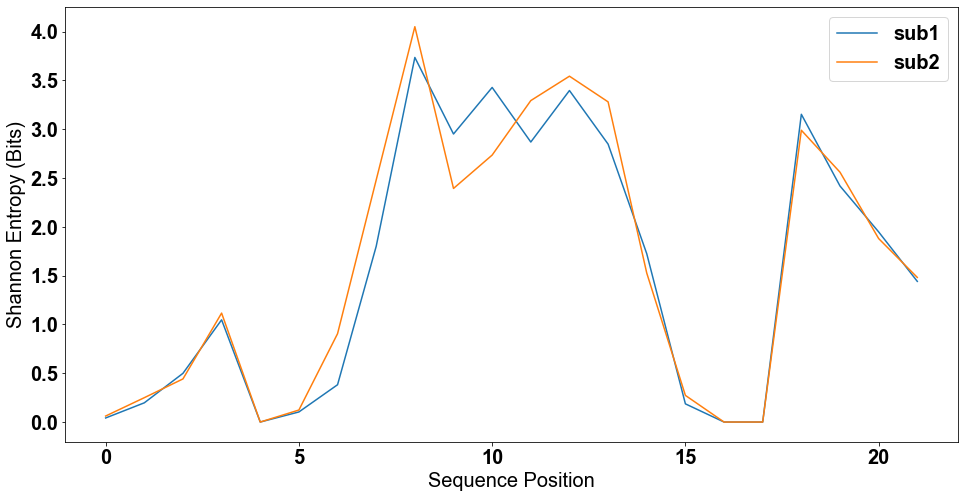

In [22]:
# Calculate the Shannon Entropy, a proxy for diversity
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
poses = len(seq_MIf)

entropy1,frequencies1=aims.calculate_shannon(np.transpose(np.array(sub1_MI)))
entropy2,frequencies2=aims.calculate_shannon(np.transpose(np.array(sub2_MI)))
pl.plot(entropy1)
pl.plot(entropy2)
pl.legend(label); pl.xlabel('Sequence Position'); pl.ylabel('Shannon Entropy (Bits)')

if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(0,4.2,100),'black',linewidth = 3)
#pl.savefig('AIMS_entropy.pdf',format='pdf')

Text(0.5, 1.0, 'sub2')

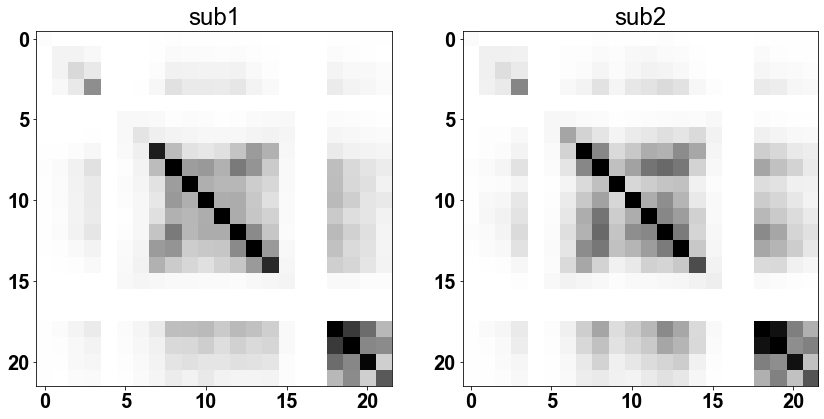

In [23]:
# And then the mutual information:
fig, ax = pl.subplots(1, 2,squeeze=False,figsize=(14,10))

MI1,entropy_cond1,counted1=aims.calculate_MI(np.transpose(np.array(sub1_MI)))
MI2,entropy_cond2,counted2=aims.calculate_MI(np.transpose(np.array(sub2_MI)))

ax[0,0].imshow(MI1,vmin=0,vmax=2,cmap=cm.Greys)
ax[0,1].imshow(MI2,vmin=0,vmax=2,cmap=cm.Greys)
#pl.colorbar(x)

# Help Guide the eyes a bit
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(0,poses,100),'black',linewidth = 3)
        ax[0,0].plot( np.linspace(0,poses,100), (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100) ,'black',linewidth = 3)
        ax[0,1].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(0,poses,100),'black',linewidth = 3)
        ax[0,1].plot( np.linspace(0,poses,100), (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100) ,'black',linewidth = 3)

ax[0,0].set_title(label[0])
ax[0,1].set_title(label[1])
#pl.savefig('AIMS_MI.pdf',format='pdf')

Text(0, 0.5, 'Sequence Position')

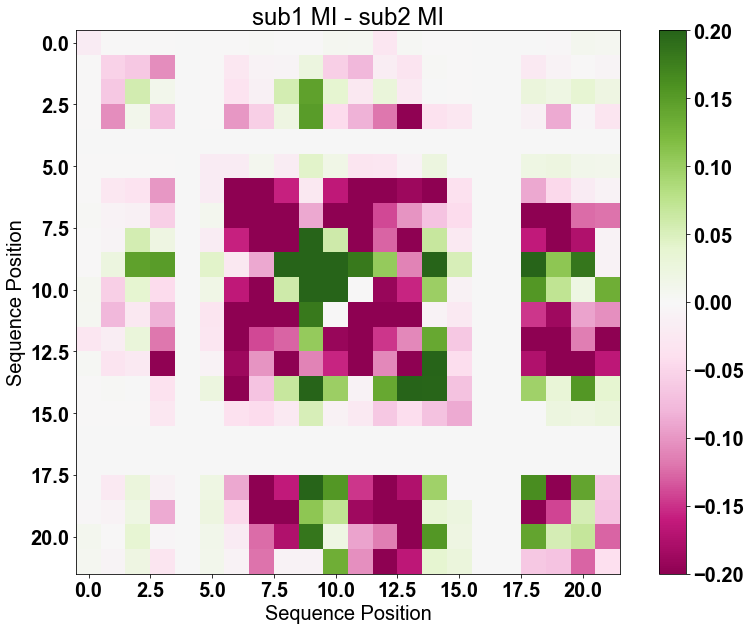

In [24]:
# A bit easier to look at the DIFFERENCE in mutual information:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(14,10))
x = pl.imshow(MI1 - MI2, cmap=cm.PiYG, vmin = -0.2, vmax = 0.2)
pl.colorbar(x); pl.title(label[0]+ ' MI - ' + label[1] + ' MI')

# Help Guide the eyes a bit
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(0,poses,100),'black',linewidth = 3)
        ax[0,0].plot( np.linspace(0,poses,100), (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100) ,'black',linewidth = 3)

pl.xlabel('Sequence Position'); pl.ylabel('Sequence Position')
#pl.savefig('AIMS_MIdiff',format='pdf')

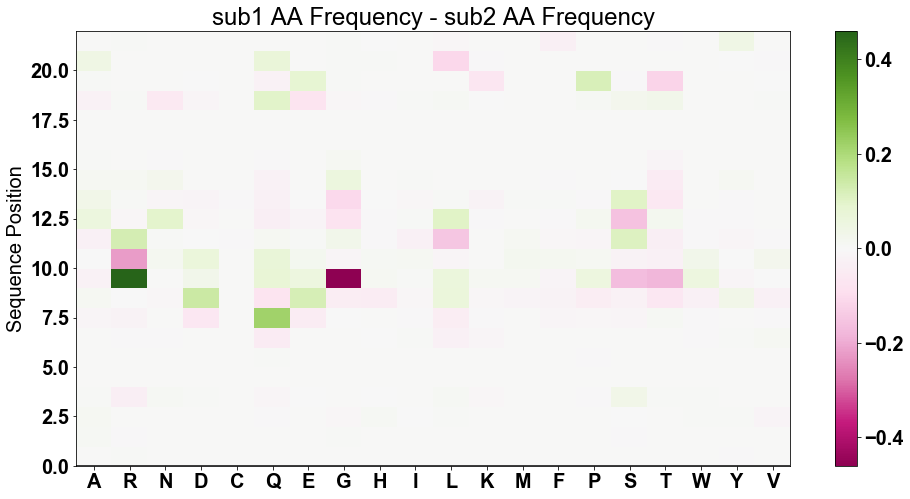

In [25]:
# Calculate the probabilities of seeing each amino acid at each position
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
pl.title(label[0]+ ' AA Frequency - ' + label[1] + ' AA Frequency')
freqMax = np.max(frequencies1[:,1:]-frequencies2[:,1:]); freqMin = np.min(frequencies1[:,1:]-frequencies2[:,1:])
freqBound = max(abs(freqMax),abs(freqMin))
x=ax[0,0].pcolormesh(frequencies1[:,1:]-frequencies2[:,1:],vmin=-freqBound,vmax=freqBound,cmap=cm.PiYG)
AA_key=['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
pl.colorbar(x); pl.ylabel('Sequence Position')
xax=pl.setp(ax,xticks=np.arange(20)+0.5,xticklabels=AA_key)

place=0
if type(mat_size) == int:
    pl.plot(np.arange(21),place*np.ones(21),'black')
else:
    for i in mat_size:
        place += i
        pl.plot(np.arange(21),place*np.ones(21),'black')

#pl.savefig('AIMS_AAprob.pdf', format='pdf')# dpi=1000)

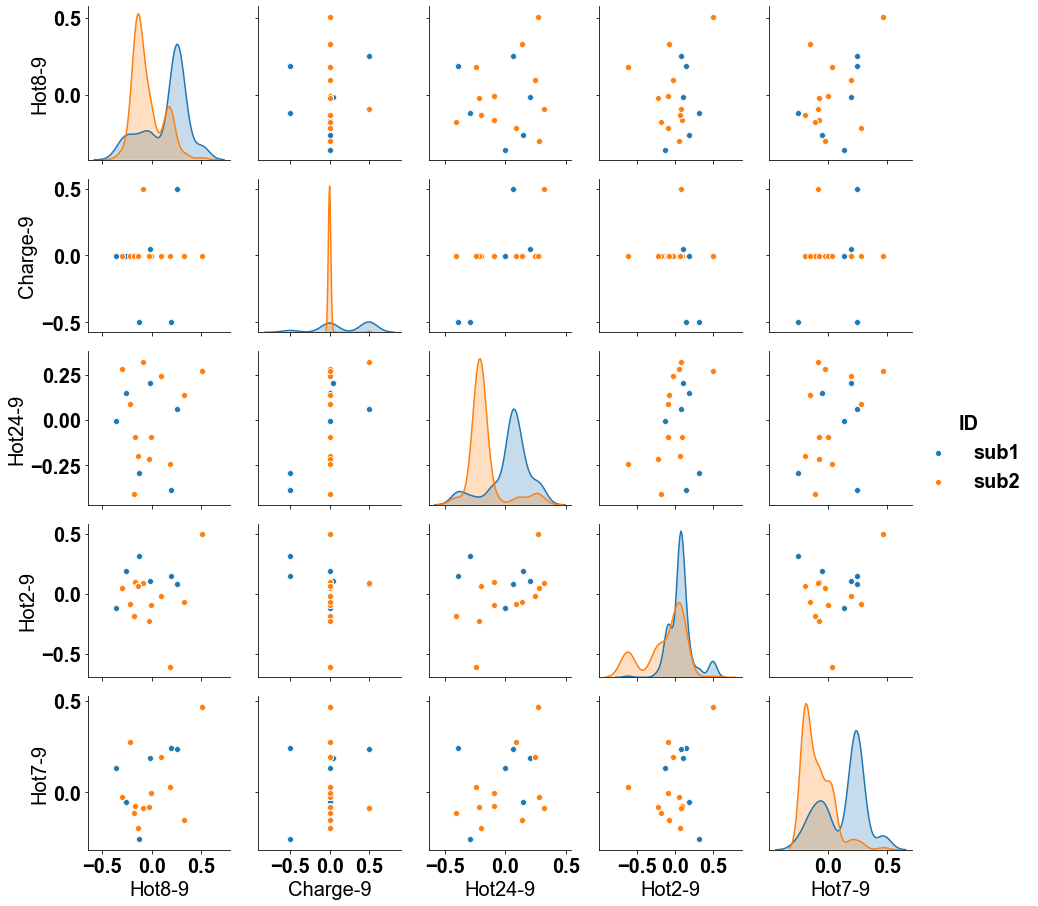

In [26]:
# Show the top properties that differentiate the two populations
# show_top = how many of these top values do you want to show? don't recommend more than ~5
# solely due to how busy the figure gets
# Again, see eLife paper for biophysical property definitions
import seaborn as sns
show_top = 5
dset_parse = parsed_mat[top_names[0:show_top]]
dset_ID_pre1 = full_big['ID']
dset_ID_pre2 = dset_ID_pre1.replace(1.0,label[0])
dset_ID = dset_ID_pre2.replace(2.0,label[1])

bigass_parse_dset = pandas.concat([dset_parse,dset_ID],axis = 1)
sns.pairplot(bigass_parse_dset,hue = 'ID')
#pl.savefig('AIMS_pairplot.pdf', format='pdf')# dpi=1000)